- [**I. Data & Package**](#dnp)
- [**II. Portfolio Selection: Volatility Decile Portfolio Strategy**](#ps)
- [**III. Portfolio Weights: Equal-weighted Method**](#pw)
- [**IV.Trading Signal: Technical Indicator & Breakout**](#ts)
- [**V.Strategy Performance Metrics: Sharpe Ratio, Culmulative Return, Maximum Drawdown**](#sp)

<a id='dnp'></a> 
## Data & Packages
  - S&P 500 component stocks
  - Time period for portfolio construction: 2010-1-1 - 2014-12-31
  - Time period for back-testing: 2015-1-1 - 2022-12-31  

In [1]:
# ----- Import necessary packages -----
import datetime
import yfinance as yf

import numpy as np #for data manipulation
import pandas as pd #for data manipulation
import matplotlib.pyplot as plt #for chart
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# ----- Select Parameters -----
# set up start and end date for data downloading
data_start = '2010-1-1'
data_end = '2022-12-31'

# set up end date for portfolio selection (start date is data_start)
port_end = '2015-1-1'

# default time period for strategy backtesting: port_end to data_end

# Moving Average: look-back time period
MA_period = 40

# Breakout: look-back time period
BO_period = 3

# Bollinger Band: MA look-back period, std look-back period, and number of STDs
BB_sma_period = 20
BB_std_period = 20
BB_num_std = 2

In [3]:
# ----- Import data -----
# read SPY component companies from wiki 
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
tickers=table[0]['Symbol']
tickers=list(tickers)

# retreive data from yahoo finance 
SPY = yf.download(tickers, start=data_start, end=data_end)['Adj Close']
SPY.head()

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04 00:00:00,20.301367,4.496875,37.163265,6.505279,NaN,21.831722,19.433033,7.994444,32.836597,37.090000,...,41.963722,13.504494,41.677597,32.242287,NaN,19.616245,53.094772,28.670000,11.041594,NaN
2010-01-05 00:00:00,20.080833,5.005958,36.942371,6.516528,NaN,21.675959,19.276033,7.967778,33.039536,37.700001,...,44.515926,13.344339,41.840340,31.858986,NaN,19.549162,54.775555,28.620001,11.430904,NaN
2010-01-06 00:00:00,20.009487,4.798555,37.264488,6.412873,NaN,21.471004,19.383076,7.933333,33.390770,37.619999,...,43.931999,13.369961,42.201969,32.068874,NaN,19.409405,54.757858,28.400000,12.424895,NaN
2010-01-07 00:00:00,19.983540,4.939964,37.255291,6.401017,NaN,21.126684,19.543650,7.886667,33.359554,36.889999,...,44.870205,13.312308,42.069370,32.488678,NaN,19.403816,56.014008,27.690001,13.816483,NaN
2010-01-08 00:00:00,19.977051,4.845691,37.402557,6.443573,NaN,21.356234,19.643564,7.871111,33.226860,36.689999,...,44.548717,13.318712,41.900597,32.488678,NaN,19.409405,54.837467,27.600000,13.592840,NaN


In [4]:
# ----- Data Processing -----
# convert date to date time format
SPY.index = pd.to_datetime(SPY.index)
#type(SPY.index)

# caculate pct for each stock
SPY_pc = SPY[:port_end].pct_change()
SPY_pc.tail()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-24,-0.005801,0.024298,-0.005956,-0.004710,0.028905,0.001970,-0.000437,-0.004017,-0.001094,0.004840,...,-0.005208,0.022580,-0.008564,-0.004444,0.001033,0.001513,0.007594,0.003202,-0.000350,0.020247
2014-12-26,0.006078,0.010305,-0.001435,0.017677,0.011629,-0.000983,0.003282,-0.003697,-0.000657,-0.000937,...,-0.003512,0.009660,-0.006078,0.001488,0.004902,0.004808,0.000526,-0.002936,0.001402,0.008211
2014-12-29,-0.001208,0.017129,0.007625,-0.000702,0.002389,0.001311,-0.005453,0.002867,-0.008109,-0.007232,...,0.017490,0.018316,-0.001502,-0.002043,-0.002310,0.005743,-0.005868,-0.000640,0.005602,-0.004299
2014-12-30,0.000968,0.010785,-0.007381,-0.012203,-0.012511,-0.003820,0.001974,0.002355,-0.003646,-0.014164,...,-0.011765,-0.023356,-0.000537,-0.007259,-0.011066,-0.003807,0.009427,0.003459,-0.001741,-0.014996
2014-12-31,-0.010394,0.003931,-0.004687,-0.019019,-0.012971,-0.012270,-0.014664,-0.008389,-0.009757,-0.005200,...,-0.016138,-0.012645,-0.006127,-0.001312,-0.009368,-0.005868,-0.010038,-0.011619,-0.005581,-0.007382


<a id='ps'></a> 
## Portfolio Selection: Volatility Decile Portfolio Strategy
- **What is it?**
  - When you divide the dataset into 10 equal parts, then each part is called as decile. 
  - When the dataset is ordered by volatility and then split into 10 equal parts, they are called volatility decile.
  - We pick up stocks of first (or first several) decile to form our portfolio.
- **Why this method?**
  - Gains received through technical indicator strategies are an increasing function of stocks’ volatility.
- **Implementation**
  - Step 1: Calculate STD for daily returns
  - Step 2: Annualize STD
  - Step 3: Sort the stocks by volatility
  - Step 4: Select top 10% stocks with highest volatility

In [5]:
# ----- calculate vol decile ----
# calculate annualized standard deviation
SPY_std = SPY_pc.std()*(252**0.5)*100
SPY_std

# pick up top decile stocks
SPY_vol_sort = SPY_std.sort_values(ascending = False)
top_decile = SPY_vol_sort[:int(len(SPY_vol_sort)*0.2)]

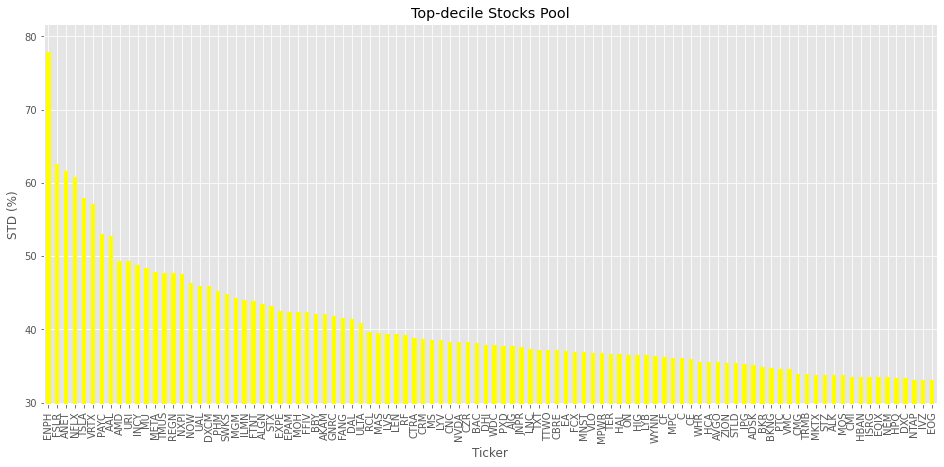

In [6]:
# ----- Visualization -----
top_decile.plot.bar(figsize = (16,7), color = 'yellow', ylim = top_decile.min()*0.9)
plt.title("Top-decile Stocks Pool")
plt.xlabel("Ticker")
plt.ylabel("STD (%)")
plt.show()

<a id='pw'></a> 
## Portfolio Weights: Equal-weighted Method
  - **What is it?**
    - For equal-weighted average return calculations, the market value is ignored since all securities in the  portfolio are assumed to have the same weight. In this project, we rebalance the portfolio every day.
  - **How to calculate average return?**

$$ \bar{R} = \sum_{k=1}^n \frac{R_k}{n} $$

  - **Implementation**
    - Step 1: Get the daily price for each stock
    - Step 2: Calculate average of daily returns of stocks
    - Step 3: Compute cumulative returns of portfolio
> **NOTE:** for asset-weighted portfolio, the average return should be 
>
>   $$ TBV = \sum_{i = 1}^n BV_i $$
>
>   $$ \bar{R} = \sum_{j=1}^n \frac{BV_j}{TBV} R_j $$
>  
> Where BV denotes the beginning market value of security 

In [7]:
# ----- Portfolio construction -----
stock_pool = SPY.loc[port_end:,top_decile.index]
stock_pool_pc = stock_pool.pct_change().dropna()
portfolio = pd.DataFrame()
portfolio['return'] = stock_pool_pc.mean(axis = 1)
portfolio['value'] = (portfolio['return'] + 1).cumprod()
portfolio.head()

,return,value
Date,,
2015-01-05,-0.020125,0.979875
2015-01-06,-0.014363,0.965802
2015-01-07,0.012657,0.978026
2015-01-08,0.023304,1.000818
2015-01-09,-0.006418,0.994395


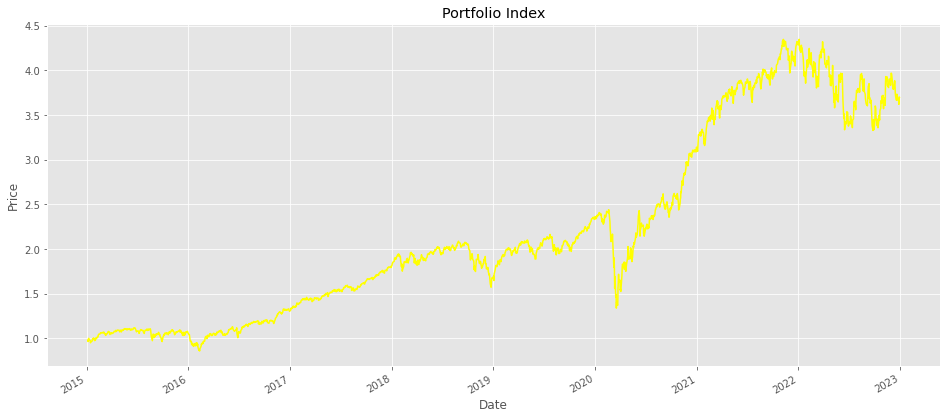

In [8]:
# ----- Visualization -----
portfolio.value.plot(color = 'yellow', figsize = (16, 7))
plt.title("Portfolio Index")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

<a id='ts'></a> 
## IV. Trading Signal: Moving Average + Breakout + Bollinger Band
- In Quantra course, the strategy involves moving averge and breakout. However, based on my previous trading experience, Bollinger Band could provide a good sense of price movement. Thus, I incorporate it into indicator pool.
- **Moving Average**
  - **How to use it?**
    - If the price crosses beyond moving average, it is likely price goes further upward.
    - If the price crosses below moving average, it is likely price goes further downward.
  - **Limitation**
    - Moving averages work in a trending market. However, if the asset prices keep following a cyclic pattern without any trend, the moving average won't generate any signals.
    - Moving average of different time span could provide conflicting signals. 
- **Breakout Strategy**
  - **How to use it?**
    - If the price goes over the maximum value of a past period, it is likely price goes further upward.
  - **Why**
    - This jump is usually the result of an accumulation phase. When the price is moving sideways, it tends to accumulate a lot of positions. Once there are enough positions on one side (buying or selling), the pressure builds up. And it suddenly bursts, resulting in a jump in the price. You can say that the price breakout is due to a build-up of momentum.
    - Similarly, when the price is moving in the same direction for a given period, it tends to lose momentum after a while. There is an accumulation of positions on the other side, leading to a reversal and a breakout.
- **Bollinger Band**
  - **What is it?**
    - Bollinger band is consisted of three lines: Moving avaerge + 2 STD(upper bound), Moving average, Moving avaerge - 2 STD(lower bound)   
  - **How to use it**
    - When the price is between the range of upper bound and moving average, it is likely to be an upward trend.
    - When the price is between the range of moving average and lower bound, it is likely to be an downward trend.
- **Implementation**
    - **Quantra: MA_signal & BO_signal**
      - If (price is above moving average) *AND* (price is greater than past period), then long the portfolio.
      - Otherwise, leave the market. 
    - **My Improvement #1: BB_signal**
      - If (price is between the range of upper BB band), then long the portfolio.
      - Otherwise, leave the market.    
    - **My Improvement #2: MA_signal | BB_signal | BO signal**
      - If (price is above moving average) *OR* (price is greater than past period) *OR* (price is between the range of upper BB band), then long the portfolio.
      - Otherwise, leave the market.

In [9]:
# ----- Determine trading signal -----
# Moving average
portfolio['MA_sma'] = portfolio.value.rolling(MA_period).mean()
portfolio['MA_signal'] = np.where(portfolio.value > portfolio.MA_sma, 1, 0)

# Breakout
portfolio['high'] = portfolio.value.rolling(BO_period).max()
portfolio['BO_signal'] = np.where(portfolio.value >= portfolio.high, 1, 0)

# Bolliger band
portfolio['BB_sma'] = portfolio.value.rolling(BB_sma_period).mean()
portfolio['BB_std'] = portfolio.value.rolling(BB_std_period).std()
portfolio['BB_upper'] = portfolio['BB_sma'] + BB_num_std * portfolio['BB_std']
portfolio['BB_signal'] = np.where((portfolio.value > portfolio.BB_sma) & (portfolio.value <= portfolio.BB_upper), 1, 0)

In [10]:
# ----- Visualization -----
def plot_signal(portfolio, signal_name, signals):
    portfolio['value'].plot(color='yellow')    
    plt.title(signal_name)
    plt.fill_between(portfolio.index, portfolio.value, where=(signals ==1), facecolor='y', alpha=0.2)      
    plt.ylabel('Portfolio Value',color='grey')
    
    # Plot signal values    
    signals.plot(secondary_y=True, figsize=(16,7), color='grey')
    plt.ylabel('Signal',color='grey')
    plt.show()

<a id='sp'></a> 
### V. Strategy Performance Metrics

In [11]:
def performance_metrics(portfolio, signal_name, signals):
    str_returns = portfolio['return'].shift(-1) * signals
    
    # ----- Sharpe ratio -----
    sharpe_ratio = np.mean(str_returns)/np.std(str_returns)*(252**0.5)

    # ----- Cumulative strategy returns -----
    portfolio['cum_str_returns'] = (str_returns+1).cumprod()        

    # ----- Drawdown -----  
    # Calculate the running maximum
    running_max = np.maximum.accumulate(portfolio['cum_str_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (portfolio['cum_str_returns'])/running_max - 1
    max_dd = drawdown.min()*100
    
    # ----- Output Info ------
    print("Strategy: ", signal_name)
    print('The Sharpe ratio is %.2f ' % sharpe_ratio)
    print("The cumulative returns is %2f" % portfolio['cum_str_returns'][-2])
    print('The maximum drawdown is %.2f %%' % max_dd)
    # Plot cumulative strategy returns
    portfolio['cum_str_returns'].plot(figsize=(16,7), color='yellow')
    plt.title('Strategy Returns', fontsize=14)
    plt.ylabel('Cumulative returns')
    plt.show()
    # Plot drawdowns
    drawdown.plot(color='yellow',figsize=(16,10))
    plt.title("Maximum Drawdown")
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='yellow', alpha = 0.4)
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()
    
    return [signal_name, sharpe_ratio, portfolio['cum_str_returns'][-2], max_dd]

### Quantra Strategy

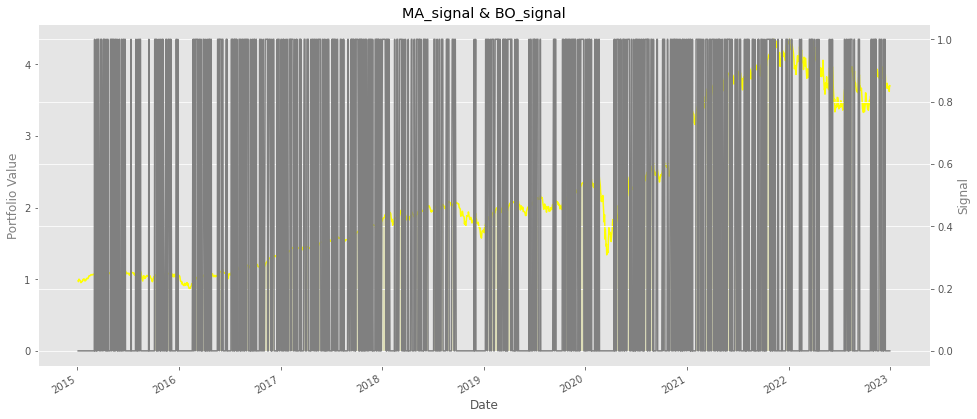

In [12]:
plot_signal(portfolio, "MA_signal & BO_signal", portfolio.MA_signal & portfolio.BO_signal)

Strategy:  MA_signal & BO_signal
The Sharpe ratio is 0.15 
The cumulative returns is 1.088849
The maximum drawdown is -21.84 %


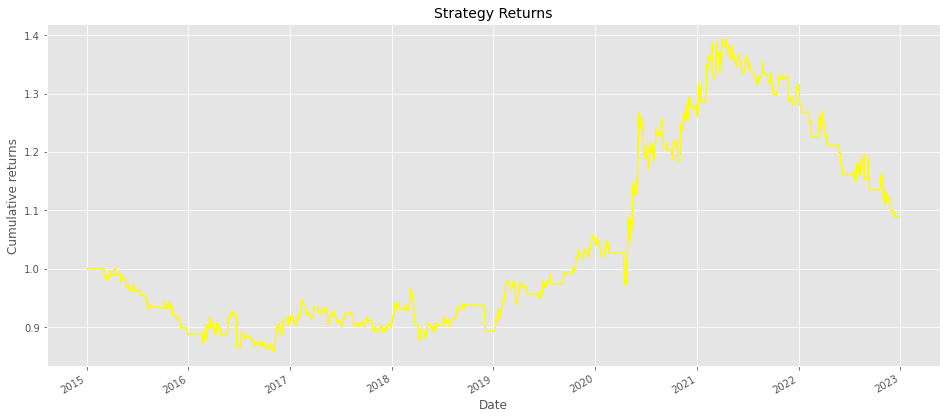

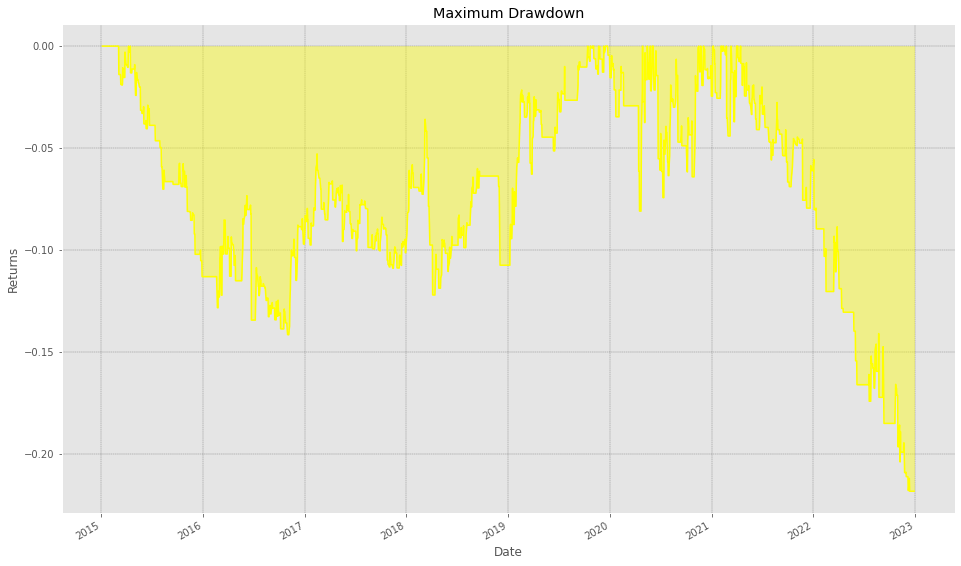

In [13]:
MAnBO = performance_metrics(portfolio, "MA_signal & BO_signal", portfolio.MA_signal & portfolio.BO_signal)

### My Improvement #1: BB_signal

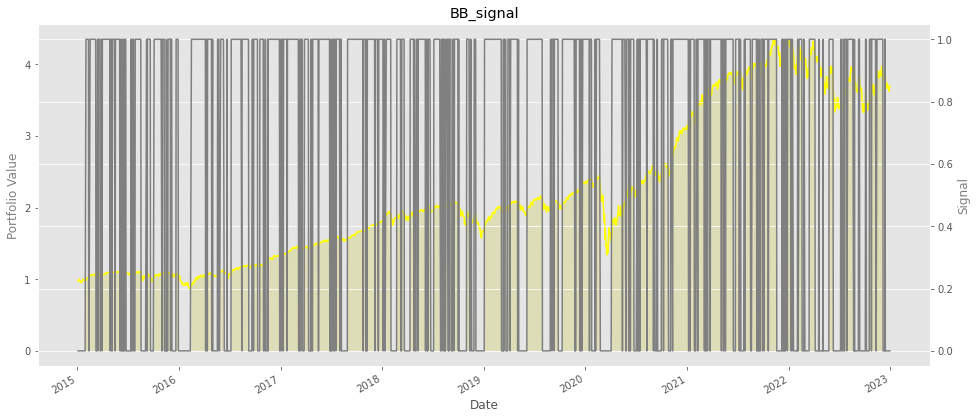

In [14]:
plot_signal(portfolio, 'BB_signal', portfolio.BB_signal)

Strategy:  BB_signal
The Sharpe ratio is 0.97 
The cumulative returns is 2.901018
The maximum drawdown is -22.69 %


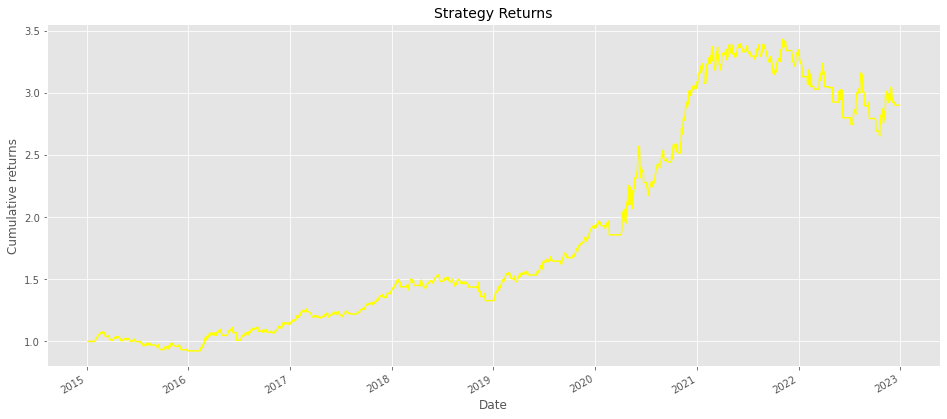

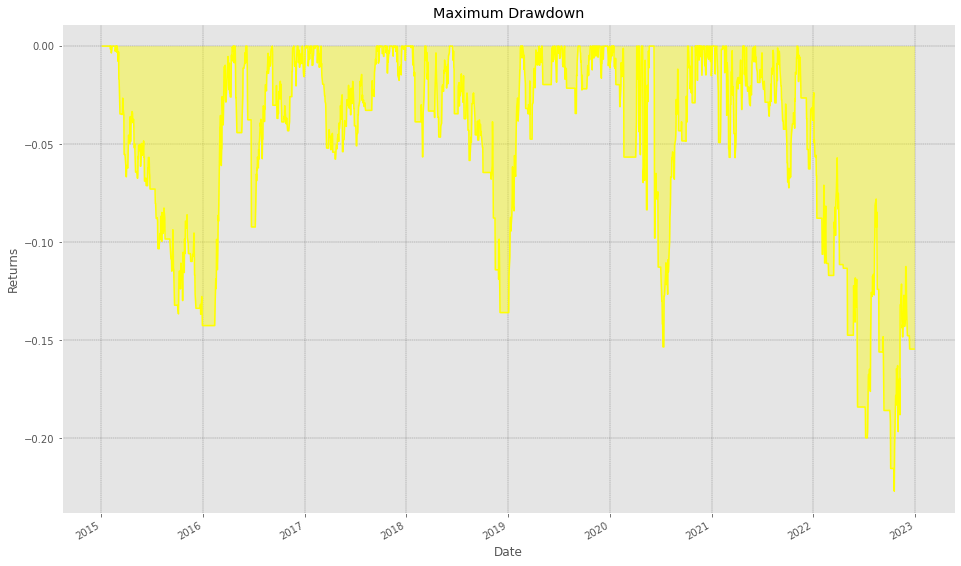

In [15]:
BB = performance_metrics(portfolio, "BB_signal", portfolio.BB_signal)

### My Improvement #2: MA_signal | BB_signal | BO signal

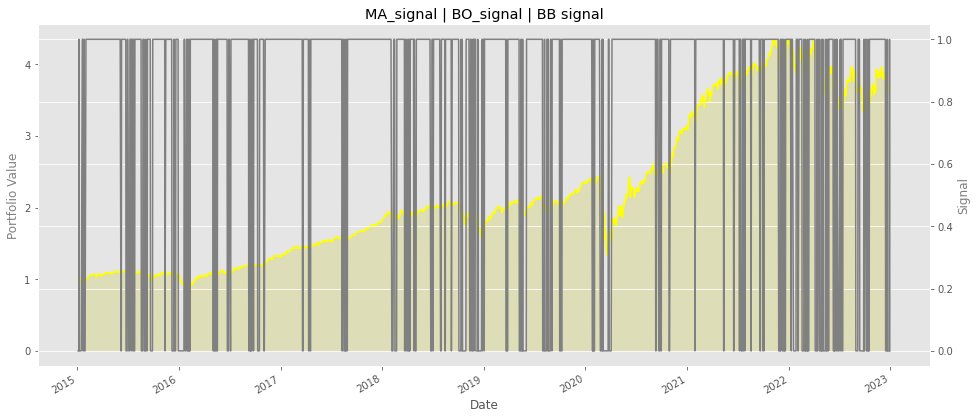

In [16]:
plot_signal(portfolio, "MA_signal | BO_signal | BB signal", portfolio.MA_signal | portfolio.BO_signal | portfolio.BB_signal)

Strategy:  MA_signal | BB_signal | BO signal
The Sharpe ratio is 0.98 
The cumulative returns is 3.588902
The maximum drawdown is -24.87 %


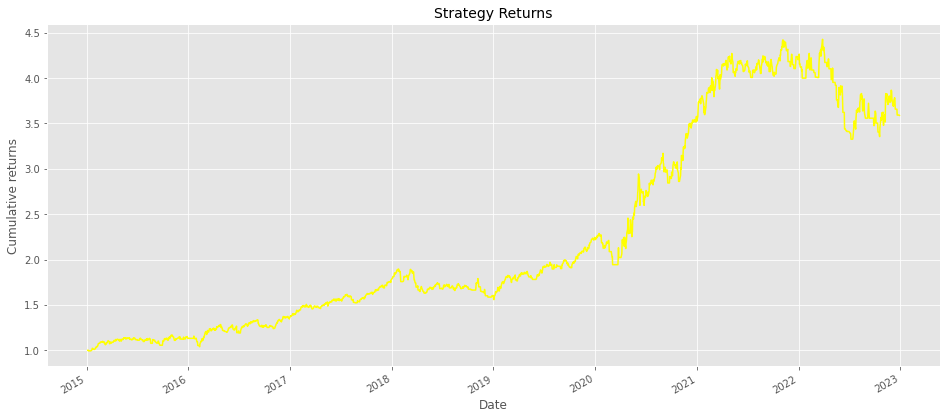

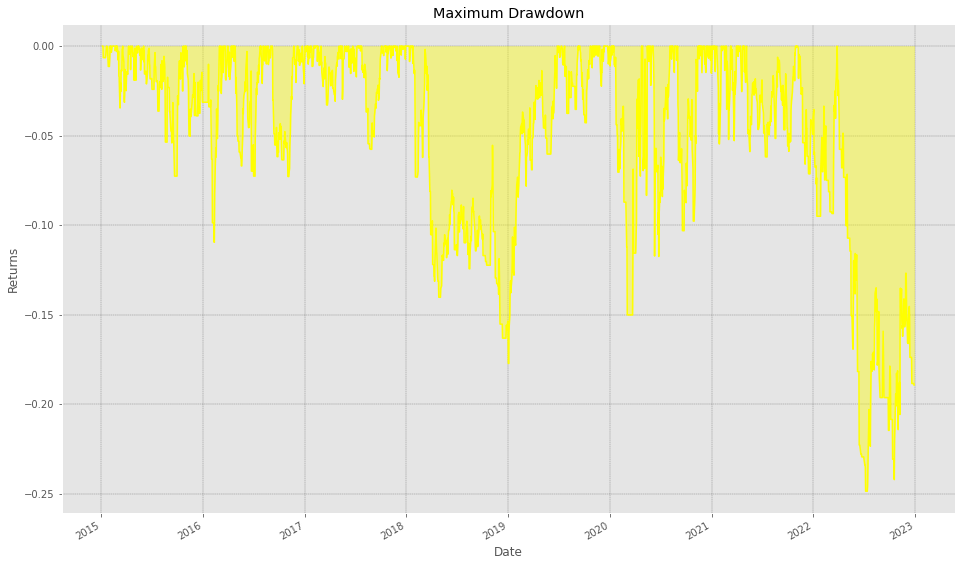

In [17]:
MAoBOoBB = performance_metrics(portfolio, "MA_signal | BB_signal | BO signal", portfolio.MA_signal | portfolio.BO_signal | portfolio.BB_signal)

### Summary

In [18]:
# Creating performance table
results = {'Strategy': ['Sharpe Ratio','Cumulative Return', 'Maximum Drawdown'],
MAnBO[0]: [MAnBO[1], MAnBO[2], MAnBO[3]],
BB[0]: [BB[1], BB[2], BB[3]],
MAoBOoBB[0]: [MAoBOoBB[1], MAoBOoBB[2], MAoBOoBB[3]],
}
df = pd.DataFrame(results, columns = ['Strategy', MAnBO[0], BB[0], MAoBOoBB[0]])
df.set_index("Strategy", inplace=True)
df = df.T
df

Strategy,Sharpe Ratio,Cumulative Return,Maximum Drawdown
MA_signal & BO_signal,0.154432,1.088849,-21.837698
BB_signal,0.969737,2.901018,-22.687418
MA_signal | BB_signal | BO signal,0.984896,3.588902,-24.868614
